In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
start_val = 0

In [11]:
df = pd.read_csv('../csv/time_benchmark/rep100_p3_bias1_cifarinc.csv')

configs = [
    ('TensorSketch', df[(df['proj'] == 'countsketch_scatter')]),
#     ('Rademacher real', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == False)]),
#     ('Rademacher comp..', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == True)])
    ('TensorSRHT real', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]),
    ('TensorSRHT comp.', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == True)])
]

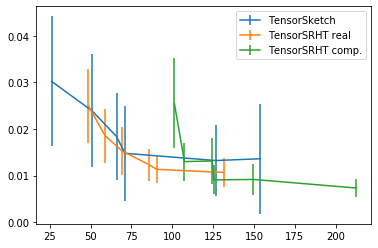

In [11]:
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['metric_time_ms'].values[start_val:], config[1]['frob_mean'].values[start_val:], yerr=config[1]['frob_std'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

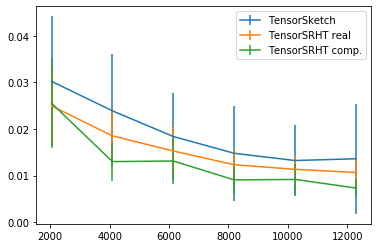

In [12]:
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['D'].values[start_val:], config[1]['frob_mean'].values[start_val:], yerr=config[1]['frob_std'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

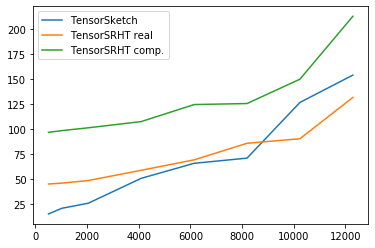

In [12]:
# full cov
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.plot(config[1]['D'].values[start_val:], config[1]['metric_time_ms'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

## MNIST normal

In [11]:
df = pd.read_csv('../csv/time_benchmark/rep100_p3_bias1_mnist.csv')

configs = [
    ('TensorSketch', df[(df['proj'] == 'countsketch_scatter')]),
#     ('Rademacher real', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == False)]),
#     ('Rademacher comp..', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == True)])
    ('TensorSRHT real', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]),
    ('TensorSRHT comp.', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == True)])
]

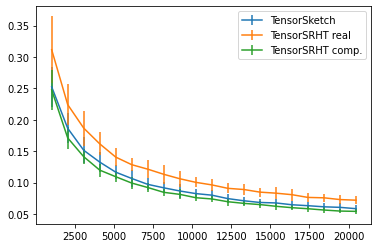

In [4]:
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['D'].values, config[1]['frob_mean'].values, yerr=config[1]['frob_std'].values, label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

D: [ 1024.  2048.  3072.  4096.  5120.  6144.  7168.  8192.  9216. 10240.
 11264. 12288. 13312. 14336. 15360.]


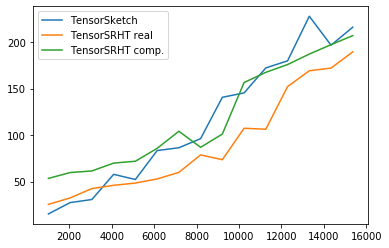

In [34]:
# full cov, MNIST conv
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
print('D:', configs[0][1]['D'].values[start_val:])
for config in configs:
    plt.plot(config[1]['D'].values[start_val:], config[1]['metric_time_ms'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

D: [ 1024.  2048.  3072.  4096.  5120.  6144.  7168.  8192.  9216. 10240.
 11264. 12288. 13312. 14336. 15360. 16384. 17408. 18432. 19456. 20480.]


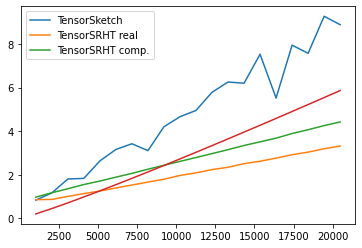

In [12]:
# full cov, MNIST conv
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
print('D:', configs[0][1]['D'].values)
for config in configs:
    plt.plot(config[1]['D'].values, config[1]['metric_time_ms'].values, label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.plot(config[1]['D'].values, 1e-5*(config[1]['D'].values*np.log2(config[1]['D'].values) + config[1]['D'].values*(np.log2(config[1]['D'].values + 3*4))))
plt.legend()
plt.show()

D: [ 1024.  2048.  3072.  4096.  5120.  6144.  7168.  8192.  9216. 10240.
 11264. 12288. 13312. 14336. 15360. 16384. 17408. 18432. 19456. 20480.]


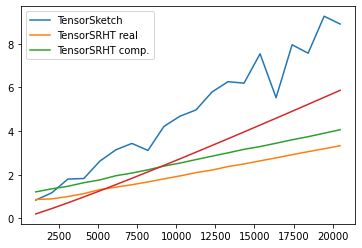

In [10]:
# full cov, MNIST conv
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
print('D:', configs[0][1]['D'].values)
for config in configs:
    plt.plot(config[1]['D'].values, config[1]['metric_time_ms'].values, label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.plot(config[1]['D'].values, 1e-5*(config[1]['D'].values*np.log2(config[1]['D'].values) + config[1]['D'].values*(np.log2(config[1]['D'].values + 3*4))))
plt.legend()
plt.show()

D: [ 1024.  2048.  3072.  4096.  5120.  6144.  7168.  8192.  9216. 10240.
 11264. 12288. 13312. 14336. 15360.]


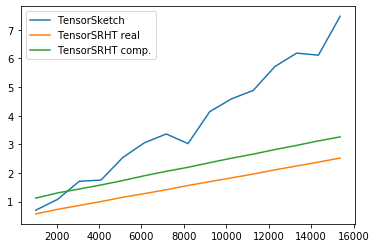

In [5]:
# full cov, MNIST conv
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
print('D:', configs[0][1]['D'].values)
for config in configs:
    plt.plot(config[1]['D'].values, config[1]['metric_time_ms'].values, label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

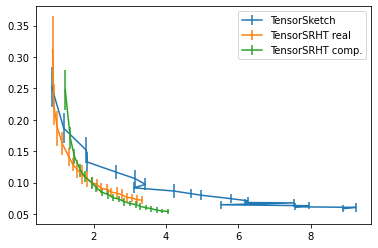

In [6]:
# full cov
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['metric_time_ms'].values, config[1]['frob_mean'].values, yerr=config[1]['frob_std'].values, label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

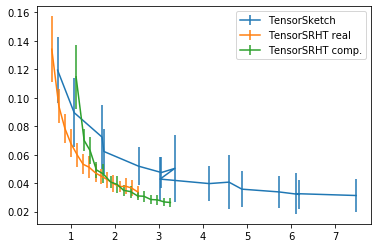

In [7]:
# full cov
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['metric_time_ms'].values, config[1]['frob_mean'].values, yerr=config[1]['frob_std'].values, label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

# MNIST Conv

In [16]:
df = pd.read_csv('../csv/time_benchmark/rep100_p3_bias1_mnist_fast_2.csv')

configs = [
#     ('TensorSketch', df[(df['proj'] == 'countsketch_scatter')]),
#     ('Rademacher real', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == False)]),
#     ('Rademacher comp..', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == True)]),
    ('TensorSRHT real', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]),
    ('TensorSRHT comp.', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == True)])
]

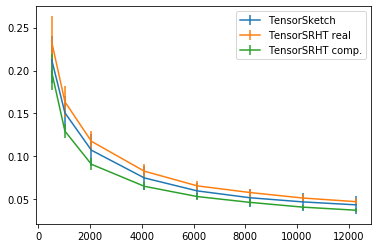

In [26]:
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['D'].values[start_val:], config[1]['frob_mean'].values[start_val:], yerr=config[1]['frob_std'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

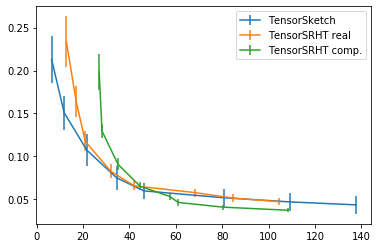

In [28]:
# full cov
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['metric_time_ms'].values[start_val:], config[1]['frob_mean'].values[start_val:], yerr=config[1]['frob_std'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

D: [  512.  1024.  2048.  4096.  6144.  8192. 10240. 12288.]


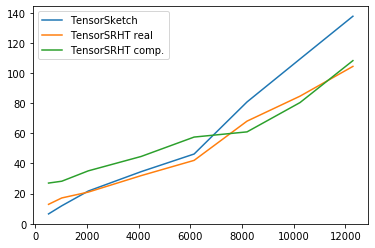

In [5]:
# full cov, MNIST conv
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
print('D:', configs[0][1]['D'].values[start_val:])
for config in configs:
    plt.plot(config[1]['D'].values[start_val:], config[1]['metric_time_ms'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

D: [ 512. 1024. 1536. 2048. 2560. 3072. 3584. 4096. 4608. 5120.]


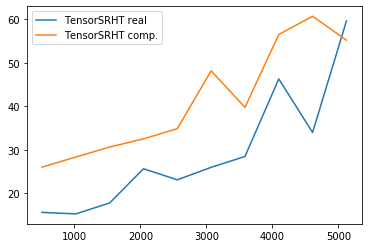

In [15]:
# full cov, MNIST conv
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
print('D:', configs[0][1]['D'].values[start_val:])
for config in configs:
    plt.plot(config[1]['D'].values[start_val:], config[1]['metric_time_ms'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

D: [ 512. 1024. 1536. 2048. 2560. 3072. 3584. 4096. 4608. 5120.]


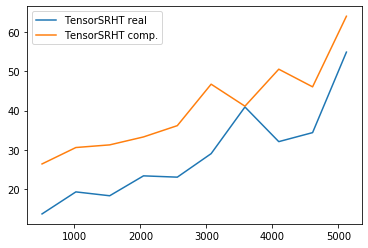

In [17]:
# full cov, MNIST conv
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
print('D:', configs[0][1]['D'].values[start_val:])
for config in configs:
    plt.plot(config[1]['D'].values[start_val:], config[1]['metric_time_ms'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

## Drive

In [18]:
df = pd.read_csv('../csv/time_benchmark/rep100_p3_bias1_drive.csv')

configs = [
    ('TensorSketch', df[(df['proj'] == 'countsketch_scatter')]),
#     ('Rademacher real', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == False)]),
#     ('Rademacher comp..', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == True)]),
    ('TensorSRHT real', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]),
    ('TensorSRHT comp.', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == True)])
]

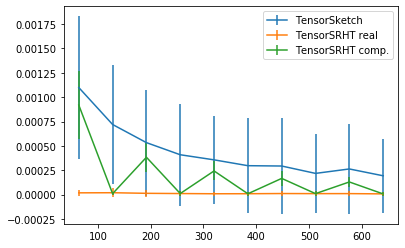

In [20]:
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['D'].values[start_val:], config[1]['frob_mean'].values[start_val:], yerr=config[1]['frob_std'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

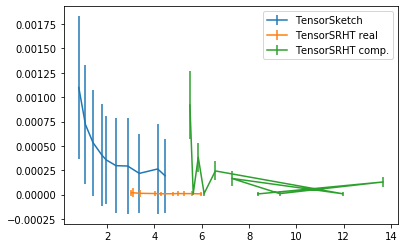

In [22]:
# full cov
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['metric_time_ms'].values[start_val:], config[1]['frob_mean'].values[start_val:], yerr=config[1]['frob_std'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

D: [ 64. 128. 192. 256. 320. 384. 448. 512. 576. 640.]


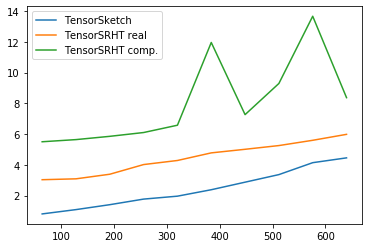

In [19]:
# full cov, MNIST conv
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
print('D:', configs[0][1]['D'].values[start_val:])
for config in configs:
    plt.plot(config[1]['D'].values[start_val:], config[1]['metric_time_ms'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

## Mocap

In [35]:
df = pd.read_csv('../csv/time_benchmark/rep100_p3_bias1_mocap.csv')

configs = [
    ('TensorSketch', df[(df['proj'] == 'countsketch_scatter')]),
#     ('Rademacher real', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == False)]),
#     ('Rademacher comp..', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == True)]),
    ('TensorSRHT real', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]),
    ('TensorSRHT comp.', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == True)])
]

D: [  64.  128.  192.  256.  320.  384.  448.  512.  576.  640.  704.  768.
  832.  896.  960. 1024. 1088. 1152. 1216. 1280. 1344. 1408. 1472. 1536.
 1600. 1664. 1728. 1792. 1856. 1920. 1984. 2048. 2112. 2176. 2240. 2304.
 2368. 2432. 2496. 2560. 2624. 2688. 2752. 2816. 2880. 2944. 3008. 3072.
 3136. 3200.]


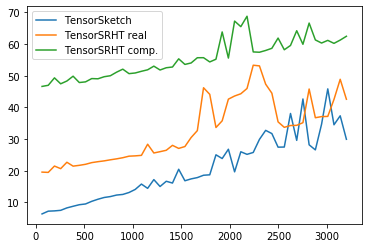

In [36]:
# full cov, MNIST conv
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
print('D:', configs[0][1]['D'].values[start_val:])
for config in configs:
    plt.plot(config[1]['D'].values[start_val:], config[1]['metric_time_ms'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

D: [  64.  128.  192.  256.  320.  384.  448.  512.  576.  640.  704.  768.
  832.  896.  960. 1024. 1088. 1152. 1216. 1280. 1344. 1408. 1472. 1536.
 1600. 1664. 1728. 1792. 1856. 1920.]


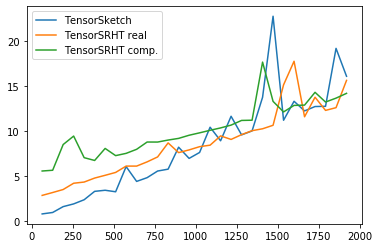

In [29]:
# full cov, MNIST conv
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
print('D:', configs[0][1]['D'].values[start_val:])
for config in configs:
    plt.plot(config[1]['D'].values[start_val:], config[1]['metric_time_ms'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

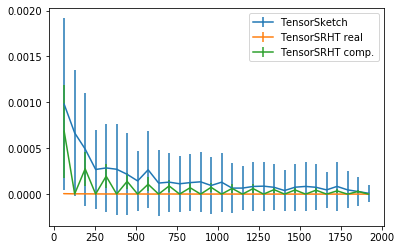

In [30]:
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['D'].values[start_val:], config[1]['frob_mean'].values[start_val:], yerr=config[1]['frob_std'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

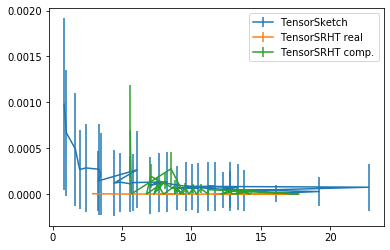

In [31]:
# full cov
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['metric_time_ms'].values[start_val:], config[1]['frob_mean'].values[start_val:], yerr=config[1]['frob_std'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

## Adult

In [6]:
df = pd.read_csv('../csv/time_benchmark/rep100_p3_bias1_adult.csv')

configs = [
    ('TensorSketch', df[(df['proj'] == 'countsketch_scatter')]),
#     ('Rademacher real', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == False)]),
#     ('Rademacher comp..', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == True)]),
    ('TensorSRHT real', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]),
    ('TensorSRHT comp.', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == True)])
]

D: [ 128.  256.  384.  512.  640.  768.  896. 1024. 1152. 1280.]


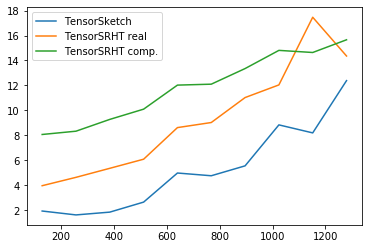

In [9]:
# full cov
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
print('D:', configs[0][1]['D'].values[:])
for config in configs:
    plt.plot(config[1]['D'].values[:], config[1]['metric_time_ms'].values[:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

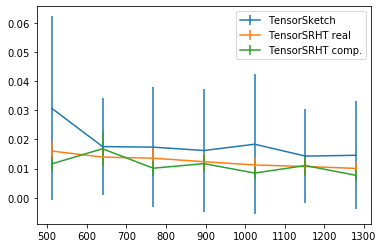

In [10]:
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['D'].values[start_val:], config[1]['frob_mean'].values[start_val:], yerr=config[1]['frob_std'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()